# Mouse line analysis

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

### Imports

In [2]:
# External packages
import logging
import os
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from interpolators import *
from filters import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

### Input datasets and main processing parameters

In [3]:
mouseline = 'line3' # Mouse line
no_slack_notify = True
kalman_gain = KALMAN_GAIN  # gain of Kalman filter
baseline_wlen = 5  # length of rolling window for baseline computation
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile in folling window for baseline evaluation
ykey_postpro = Label.ZSCORE  # variable of interest for post-processing

### Derived parameters

In [4]:
dataroot = get_data_root()
figsdir = get_output_equivalent(dataroot, 'raw', 'figs')
trialavg_root = get_output_equivalent(dataroot, 'raw', 'trial-averaged')
baseline_str = f'w{baseline_wlen:.1f}s' if baseline_wlen is not None else ''
postpro_str = f'{baseline_str}_q{baseline_quantile:.2f}'
figs_suffix = f'{mouseline}_k{kalman_gain}_{postpro_str}_{ykey_postpro}'
figs_suffix = figs_suffix.replace('/', '')
si = StackInterpolator(order=0, npast=2)
kd = KalmanDenoiser(kalman_gain) if kalman_gain > 0 else NoFilter
trialavg_dir = os.path.join(trialavg_root, postpro_str, kd.code, si.code, mouseline)

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{mouseline} batch notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if not no_slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 24/05/2022 18:16:17: line3 batch notebook started on 2022-05-24 at 18:16:17


### Load data

In [5]:

logger.info(f'loading data from {trialavg_dir}:')
data = load_mousereg_datasets(trialavg_dir)
timeseries = data['timeseries']
stats = data['stats']
stats

 24/05/2022 18:16:17: loading data from /Users/tlemaire/Documents/data/usnm/trial-averaged/w5.0s_q0.08/kd_G0.5_V0.05_npad10/si_order0_npast2/line3:
 24/05/2022 18:16:17: loading timeseries data from timeseries_mouse1_region1.csv
 24/05/2022 18:16:18: loading timeseries data from timeseries_mouse1_region2.csv
 24/05/2022 18:16:18: loading timeseries data from timeseries_mouse6_region1.csv
 24/05/2022 18:16:19: loading timeseries data from timeseries_mouse6_region2.csv
 24/05/2022 18:16:19: loading timeseries data from timeseries_mouse7_region1.csv
 24/05/2022 18:16:20: loading timeseries data from timeseries_mouse7_region2.csv
 24/05/2022 18:16:21: loading timeseries data from timeseries_mouse9_region1.csv
 24/05/2022 18:16:21: loading timeseries data from timeseries_mouse9_region2.csv
 24/05/2022 18:16:21: loading timeseries data from timeseries_mouse10_region1.csv
 24/05/2022 18:16:22: loading timeseries data from timeseries_mouse12_region1.csv
 24/05/2022 18:16:23: loading stats data

line  trial_length  duration (s)   fps  P (MPa)  \
mouse_reg       ROI run                                                     
mouse10_region1 0   0    line3         100.0           0.2  3.56     0.00   
                    1    line3         100.0           0.2  3.56     0.10   
                    2    line3         100.0           0.2  3.56     0.20   
                    3    line3         100.0           0.2  3.56     0.40   
                    4    line3         100.0           0.2  3.56     0.05   
...                        ...           ...           ...   ...      ...   
mouse9_region2  690 10   line3         100.0           0.2  3.56     0.80   
                    11   line3         100.0           0.2  3.56     0.80   
                    12   line3         100.0           0.2  3.56     0.80   
                    13   line3         100.0           0.2  3.56     0.80   
                    14   line3         100.0           0.2  3.56     0.80   

                         DC (%)  run ID  I_SPPA (W/cm2)  I_SPTA (W/cm2)  \
mouse_reg       ROI run                                                   
mouse10_region1 0   0      50.0   833.0        0.000000        0.000000   
                    1      50.0   831.0        0.309132        0.154566   
                    2      50.0   830.0        1.236530        0.618265   
                    3      50.0   829.0        4.946119        2.473059   
                    4      50.0   832.0        0.077283        0.038642   
...                         ...     ...             ...             ...   
mouse9_region2  690 10     40.0   903.0       19.784475        7.913790   
                    11     50.0   902.0       19.784475        9.892238   
                    12     60.0   908.0       19.784475       11.870685   
                    13     70.0   909.0       19.784475       13.849133   
                    14     80.0   910.0       19.784475       15.827580   

                         peak displacement velocity (um/s)  ...  \
mouse_reg       ROI run                                     ...   
mouse10_region1 0   0                             0.239623  ...   
                    1                             0.310253  ...   
                    2                             0.239767  ...   
                    3                             0.212660  ...   
                    4                             0.235659  ...   
...                                                    ...  ...   
mouse9_region2  690 10                            0.396873  ...   
                    11                            0.398805  ...   
                    12                            0.370035  ...   
                    13                            0.347023  ...   
                    14                            0.547247  ...   

                         post-stim avg Z(ΔF/F0) - pre-stim avg Z(ΔF/F0) pval  \
mouse_reg       ROI run                                                        
mouse10_region1 0   0                                             0.017342     
                    1                                             0.004588     
                    2                                             0.348739     
                    3                                             0.541310     
                    4                                             0.833705     
...                                                                    ...     
mouse9_region2  690 10                                            0.982767     
                    11                                            0.749557     
                    12                                            0.007235     
                    13                                            0.098755     
                    14                                            0.509002     

                         response type  negative  positive  weak  \
mouse_reg       ROI run                                            

### Breakdown per mouse region

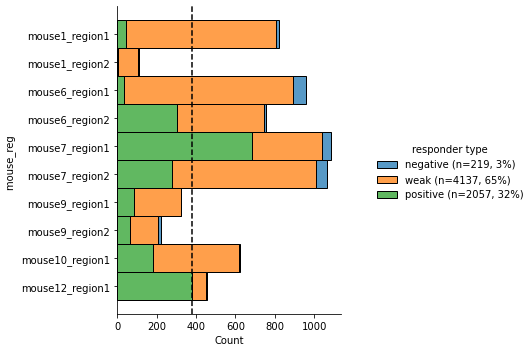

In [6]:
# Compute cell count threshold
um_per_px = 1.96  # from Bruker microscope
npx_per_line = 256  # from Bruker miscroscope
area = (um_per_px * npx_per_line)**2 / 1e6  # mm2
min_cell_count = MIN_CELL_DENSITY * area
# Plot breakdown
figs['rtype dist per mousereg'] = plot_cellcounts_by_type(
    stats, hue=Label.ROI_RESP_TYPE, min_cell_count=min_cell_count)

### Exclude datasets with low cell count

In [7]:
# Idendify datasets with a low overall cell count
celltypes = stats.groupby([Label.MOUSEREG, Label.ROI]).first()
cellcounts = celltypes.groupby(Label.MOUSEREG).count().iloc[:, 0].rename('counts')
to_exclude = cellcounts.loc[cellcounts < min_cell_count].index.values.tolist()

# Exclude them
data = exclude_datasets(data.copy(), to_exclude)
timeseries = data['timeseries']
stats = data['stats']

 24/05/2022 18:16:48: excluding ['mouse9_region2', 'mouse9_region1', 'mouse1_region2'] datasets from analysis


### Parameter dependency curves

 24/05/2022 18:16:49: sub-indexing data...
 24/05/2022 18:16:49: filtering data...
 24/05/2022 18:16:49: cross-checking filters...
 24/05/2022 18:16:49: grouping by responder type, grouping by mouse_reg, averaging and plotting mean diff Z(ΔF/F0) vs. P (MPa) ...
 24/05/2022 18:16:50: sub-indexing data...
 24/05/2022 18:16:50: filtering data...
 24/05/2022 18:16:50: cross-checking filters...
 24/05/2022 18:16:50: grouping by responder type, grouping by mouse_reg, averaging and plotting mean diff Z(ΔF/F0) vs. DC (%) ...


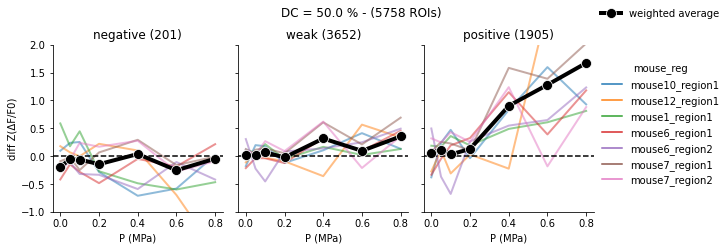

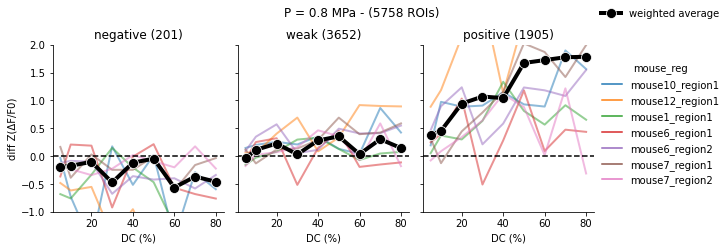

In [8]:
for pkey in [Label.P, Label.DC]:
    figs[f'{pkey}-dep {ykey_postpro}'] = plot_parameter_dependency_across_datasets(
        stats, pkey, ykey_postpro)

### Get plot-ready traces dataset

In [9]:
plt_data = get_plot_data(timeseries, stats)

 24/05/2022 18:16:51: merging timeseries and stats information...
 24/05/2022 18:17:25: adding time info to table...


### Pressure-dependent response traces

 24/05/2022 18:17:33: plotting P (MPa) dependency curves for negative responders...
 24/05/2022 18:17:33: sub-indexing data...
 24/05/2022 18:17:33: filtering data...
 24/05/2022 18:17:33: cross-checking filters...
 24/05/2022 18:17:33: grouping by mouse_reg, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 24/05/2022 18:17:35: plotting P (MPa) dependency curves for positive responders...
 24/05/2022 18:17:36: sub-indexing data...
 24/05/2022 18:17:36: filtering data...
 24/05/2022 18:17:37: cross-checking filters...
 24/05/2022 18:17:37: grouping by mouse_reg, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 24/05/2022 18:17:48: plotting P (MPa) dependency curves for weak responders...
 24/05/2022 18:17:50: sub-indexing data...
 24/05/2022 18:17:51: filtering data...
 24/05/2022 18:17:52: cross-checking filters...
 24/05/2022 18:17:54: grouping by mouse_reg, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...

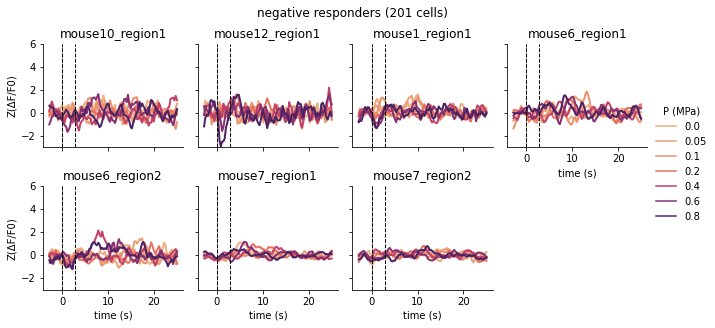

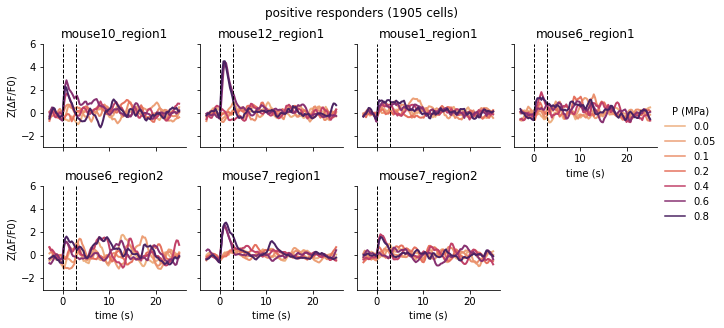

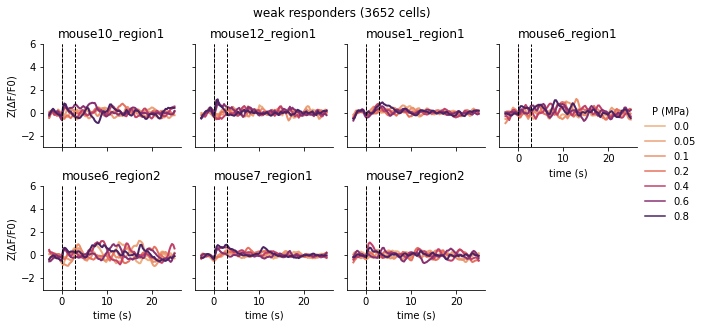

In [10]:
figs.update(
    plot_responses_across_datasets(plt_data, ykey=ykey_postpro, pkey=Label.P))

### DC-dependent response traces

 24/05/2022 18:18:18: plotting DC (%) dependency curves for negative responders...
 24/05/2022 18:18:18: sub-indexing data...
 24/05/2022 18:18:18: filtering data...
 24/05/2022 18:18:18: cross-checking filters...
 24/05/2022 18:18:18: grouping by mouse_reg, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 24/05/2022 18:18:20: plotting DC (%) dependency curves for positive responders...
 24/05/2022 18:18:21: sub-indexing data...
 24/05/2022 18:18:22: filtering data...
 24/05/2022 18:18:22: cross-checking filters...
 24/05/2022 18:18:23: grouping by mouse_reg, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 24/05/2022 18:18:37: plotting DC (%) dependency curves for weak responders...
 24/05/2022 18:18:38: sub-indexing data...
 24/05/2022 18:18:41: filtering data...
 24/05/2022 18:18:42: cross-checking filters...
 24/05/2022 18:18:43: grouping by mouse_reg, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...


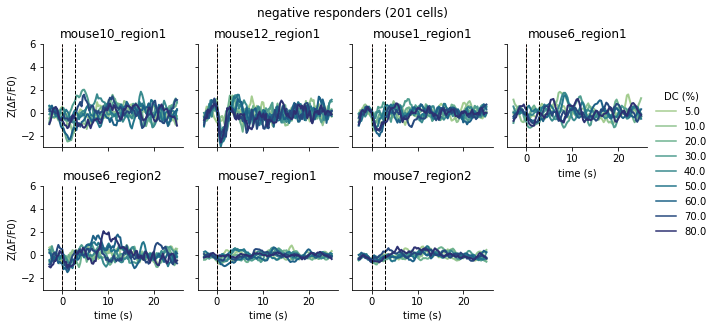

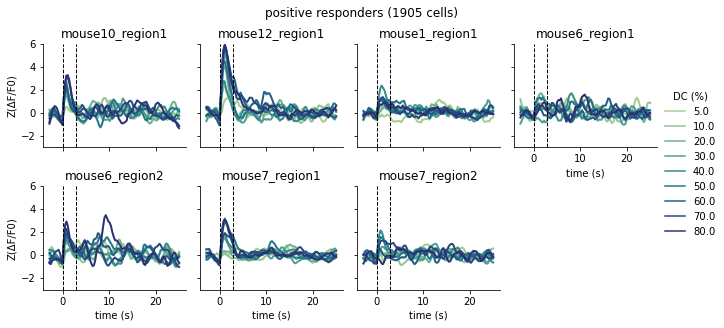

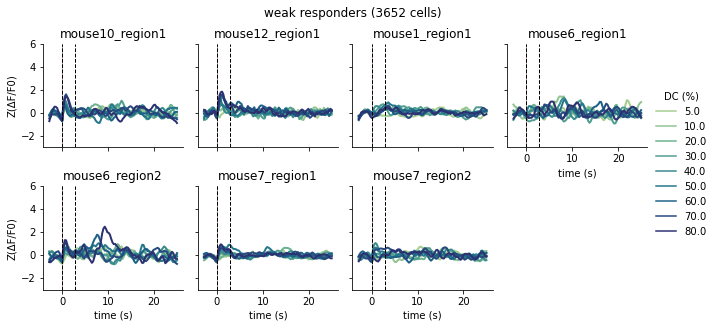

In [11]:
figs.update(
    plot_responses_across_datasets(plt_data, ykey=ykey_postpro, pkey=Label.DC))

### Average response traces across datasets (weighted)

 24/05/2022 18:19:11: sub-indexing data...
 24/05/2022 18:19:14: filtering data...
 24/05/2022 18:19:16: cross-checking filters...
 24/05/2022 18:19:18: grouping by responder type, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 24/05/2022 18:19:44: sub-indexing data...
 24/05/2022 18:19:47: filtering data...
 24/05/2022 18:19:49: cross-checking filters...
 24/05/2022 18:19:51: grouping by responder type, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...


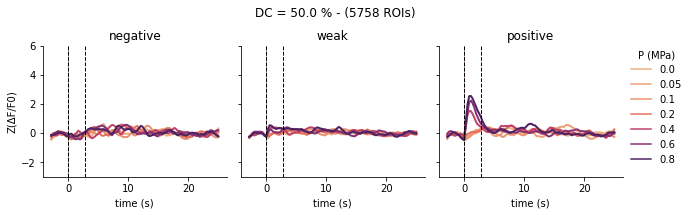

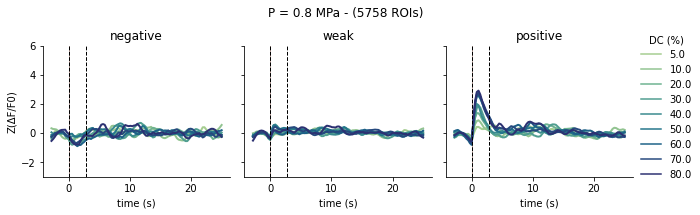

In [12]:
# Plot response curves for both input stimulation parameters  
for pkey in [Label.P, Label.DC]:
    figs[f'{ykey_postpro} vs. {pkey} by type - weighted'] = plot_responses_across_datasets(
        plt_data, ykey=ykey_postpro, pkey=pkey, avg=True)

### Average response traces across datasets (non-weighted)

 24/05/2022 18:20:26: checking for run order consistency across datasets...
 24/05/2022 18:20:28: computing average traces per dataset and condition...
 24/05/2022 18:20:33: sub-indexing data...
 24/05/2022 18:20:33: filtering data...
 24/05/2022 18:20:33: cross-checking filters...
 24/05/2022 18:20:33: grouping by responder type, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 24/05/2022 18:20:34: sub-indexing data...
 24/05/2022 18:20:34: filtering data...
 24/05/2022 18:20:34: cross-checking filters...
 24/05/2022 18:20:34: grouping by responder type, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...


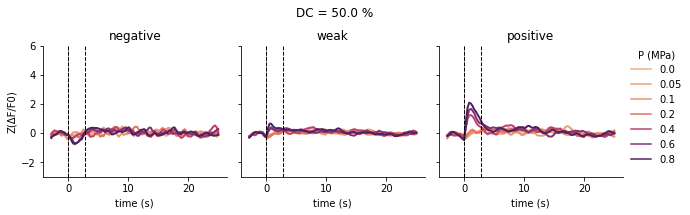

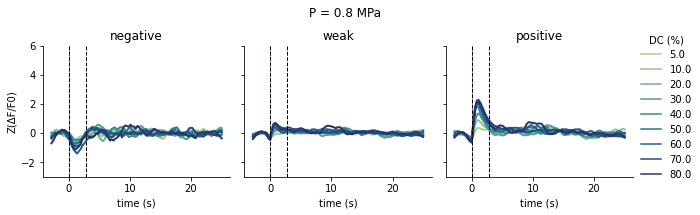

In [13]:
# Check run order consistency across datasets
logger.info('checking for run order consistency across datasets...')
params_per_run = plt_data.groupby([Label.MOUSEREG, Label.RUN]).first()[[Label.P, Label.DC]]
for k in params_per_run:
    sum_of_stds = params_per_run[k].unstack().std().sum()
    if sum_of_stds > 1e-12:
        logger.error('variation in run orders across dataset')

# Group data by mouse-region, response type, run and frame -> average
logger.info('computing average traces per dataset and condition...')
avg_plt_data = plt_data.groupby(
    [Label.MOUSEREG, Label.ROI_RESP_TYPE, Label.RUN, Label.FRAME]).mean()
avg_plt_data = resolve_columns(avg_plt_data, [Label.P, Label.DC, Label.DUR, Label.TIME])

# Plot response curves for both input stimulation parameters  
for pkey in [Label.P, Label.DC]:
    figs[f'{ykey_postpro} vs. {pkey} by type - nonweighted'] = plot_responses_across_datasets(
        avg_plt_data, ykey=ykey_postpro, pkey=pkey, avg=True)

### Save figures

In [14]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 24/05/2022 18:20:34: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2022.05.24/figs_line3_k0.5_w5.0s_q0.08_Z(ΔFF0).pdf:


100%|██████████| 13/13 [00:02<00:00,  6.39it/s]


### Notify upon completion

In [15]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'{mouseline} batch notebook completed in {tstamp_end - tstamp_start} s'
if not no_slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 24/05/2022 18:20:36: line3 batch notebook completed in 0:04:19.323415 s
